# Project: Real-Time Fraud Detection with Machine Learning

## 1. Introduction & Business Context

Credit card fraud is a multi-billion dollar problem for financial institutions. The ability to detect fraudulent transactions in real-time is crucial for minimizing financial losses and maintaining customer trust. This project aims to develop a machine learning model capable of identifying fraudulent credit card transactions from a highly imbalanced dataset.

### Key Challenges:
* **Extreme Class Imbalance:** Fraudulent transactions are rare events, often making up less than 0.2% of all transactions. This imbalance can bias traditional classification algorithms towards the majority class (non-fraudulent), leading to poor performance in identifying actual fraud.
* **Real-Time Prediction:** The model must be fast enough to score incoming transactions without introducing significant latency to the payment process.
* **Interpretability vs. Performance:** While complex models may offer higher accuracy, financial regulations often require that decisions (like blocking a transaction) be explainable. We must balance predictive power with interpretability.

This notebook will walk through the entire process of building such a model, from exploratory data analysis to model evaluation and interpretation, with a focus on techniques suited for this specific problem.

## 2. Setup and Data Loading

In [ ]:
# Install necessary libraries
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost

In [ ]:
# Install libraries for handling imbalanced data
!pip install -q imbalanced-learn

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# Load the dataset from the provided URL (Kaggle Credit Card Fraud Detection)
# This dataset is anonymized using PCA, with V1-V28 being the principal components.
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

df.head()

Dataset loaded successfully.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3. Exploratory Data Analysis (EDA)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum().max())

Missing values per column:
0


### Class Distribution Analysis

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraudulent transactions make up 0.1727% of the dataset.


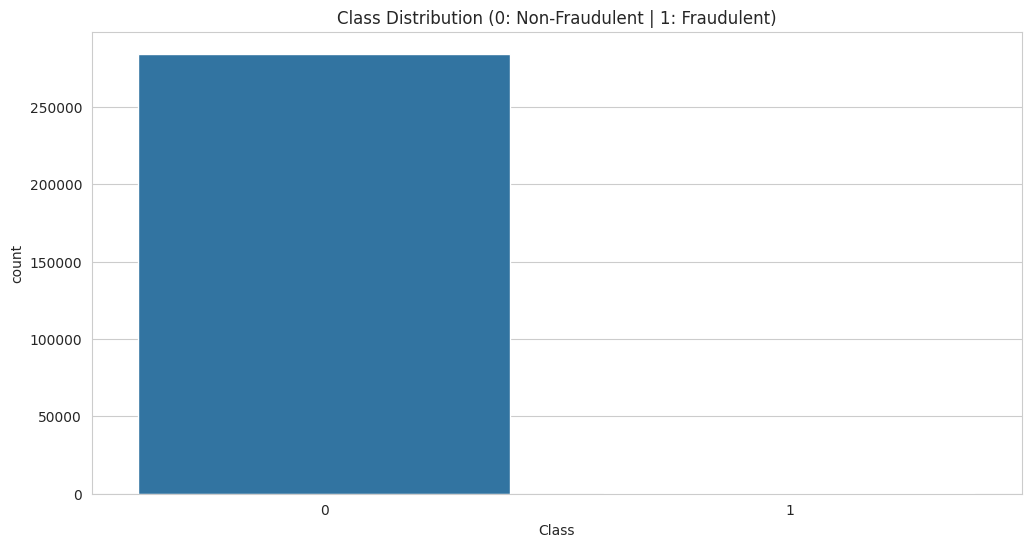

In [ ]:
class_counts = df['Class'].value_counts()
print(f"Class Distribution:\n{class_counts}")
print(f"Fraudulent transactions make up {class_counts[1] / class_counts.sum() * 100:.4f}% of the dataset.")

sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Non-Fraudulent | 1: Fraudulent)')
plt.show()

### Transaction Time and Amount Analysis

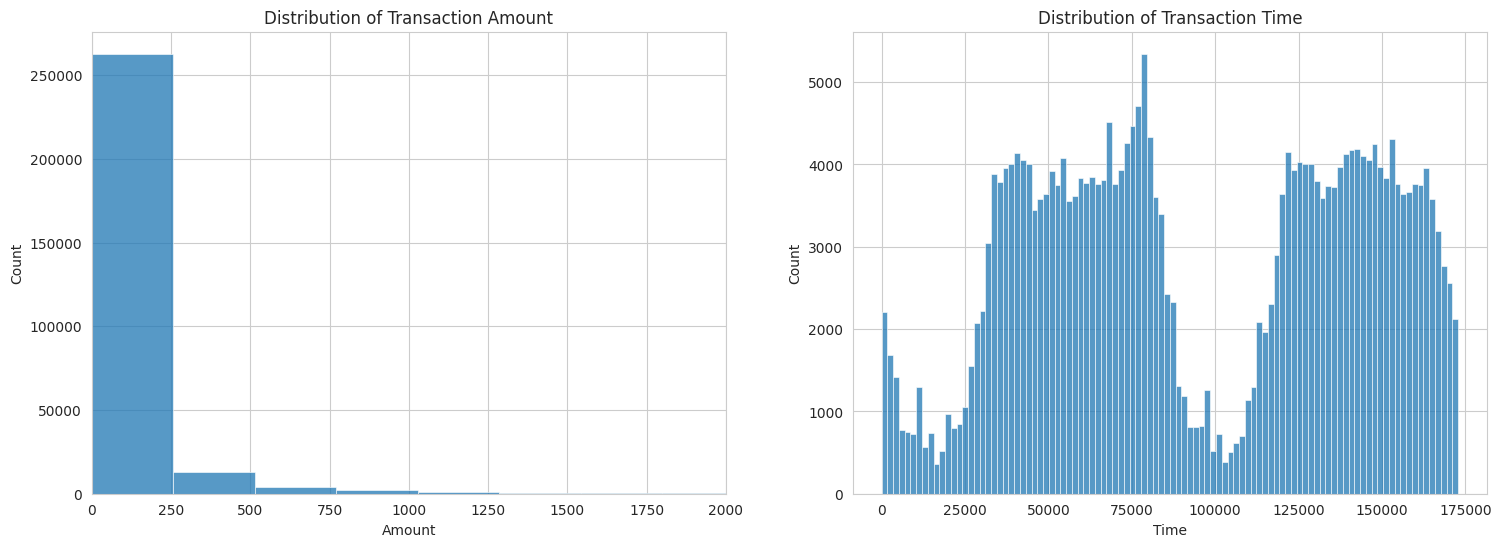

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

sns.histplot(df['Amount'], bins=100, ax=ax1)
ax1.set_title('Distribution of Transaction Amount')
ax1.set_xlim(0, 2000) # Zoom in for better visibility

sns.histplot(df['Time'], bins=100, ax=ax2)
ax2.set_title('Distribution of Transaction Time')

plt.show()

Let's compare the `Amount` for fraudulent vs. non-fraudulent transactions.

In [ ]:
print("Fraudulent Transaction Amount Stats:")
print(df[df['Class'] == 1]['Amount'].describe())

print("\nNon-Fraudulent Transaction Amount Stats:")
print(df[df['Class'] == 0]['Amount'].describe())

Fraudulent Transaction Amount Stats:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Non-Fraudulent Transaction Amount Stats:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


### Correlation Analysis

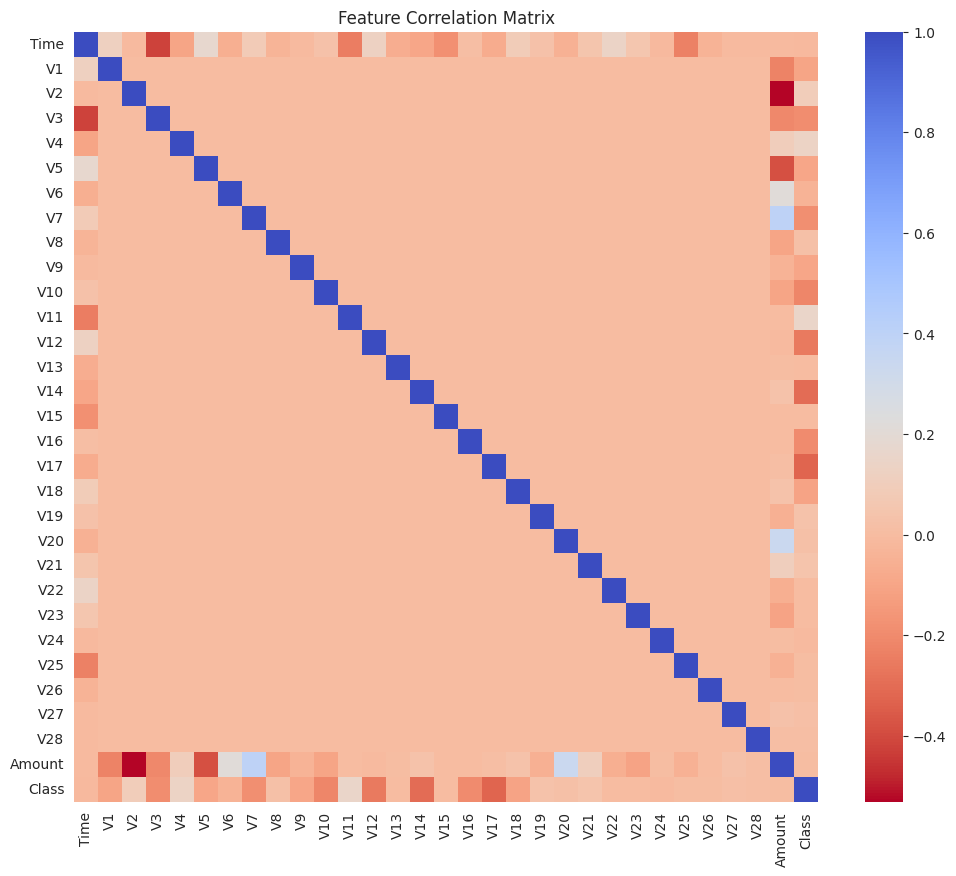

In [ ]:
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm_r', annot=False, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

## 4. Data Preprocessing

In [ ]:
# Scale 'Amount' and 'Time' features as they are not on the same scale as the PCA components
scaler = StandardScaler()
df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

print("Data scaled successfully.")
df.head()

Data scaled successfully.


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_Amount,scaled_Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


### Train-Test Split

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

# Stratified split to maintain class proportion in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (227845, 30)
Test set shape: (56962, 30)


### Handling Class Imbalance with SMOTE

We will use the Synthetic Minority Over-sampling Technique (SMOTE) to address the severe class imbalance. SMOTE generates new synthetic samples for the minority class (fraud) by interpolating between existing minority class instances. This is applied **only to the training data** to prevent data leakage into the test set.

In [ ]:
print("Class distribution before SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution before SMOTE:
Class
0    227451
1       394
Name: count, dtype: int64

Class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


## 5. Model Training and Evaluation

In [ ]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=50), # Reduced estimators
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, n_estimators=50) # Reduced estimators
}

# Train models on the SMOTE-resampled data
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_smote, y_train_smote)
print("\nAll models trained successfully.")

Training Logistic Regression...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:58:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



All models trained successfully.


### Model Performance on Test Set

--- Evaluating Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



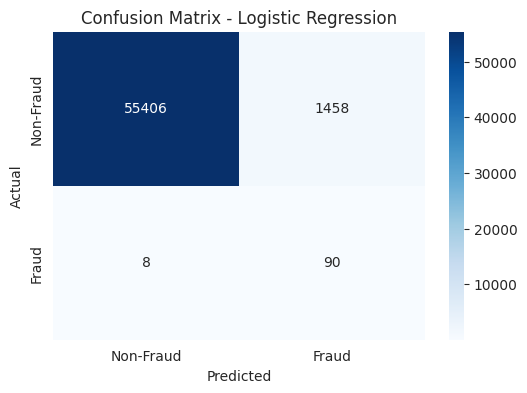

--- Evaluating Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



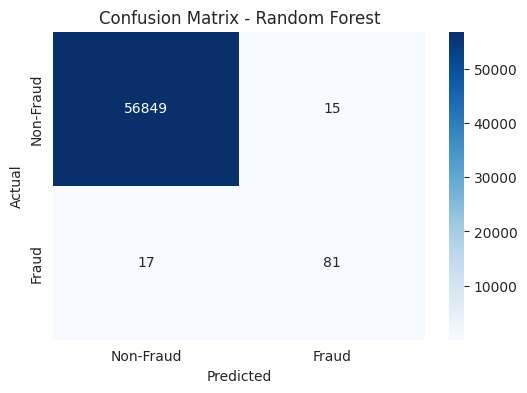

--- Evaluating XGBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.53      0.88      0.66        98

    accuracy                           1.00     56962
   macro avg       0.77      0.94      0.83     56962
weighted avg       1.00      1.00      1.00     56962



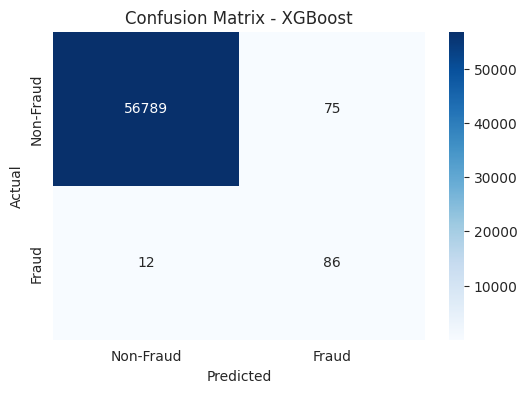

In [ ]:
results = {}

for name, model in models.items():
    print(f"--- Evaluating {name} ---")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Store probabilities for curve plotting
    results[name] = {'y_proba': y_proba}


### Precision-Recall Curve Comparison

For imbalanced classification, the Precision-Recall (PR) curve is a more informative metric than the ROC curve. It visualizes the trade-off between precision (the accuracy of positive predictions) and recall (the ability to find all positive samples). A model that performs well will maintain high precision as recall increases.

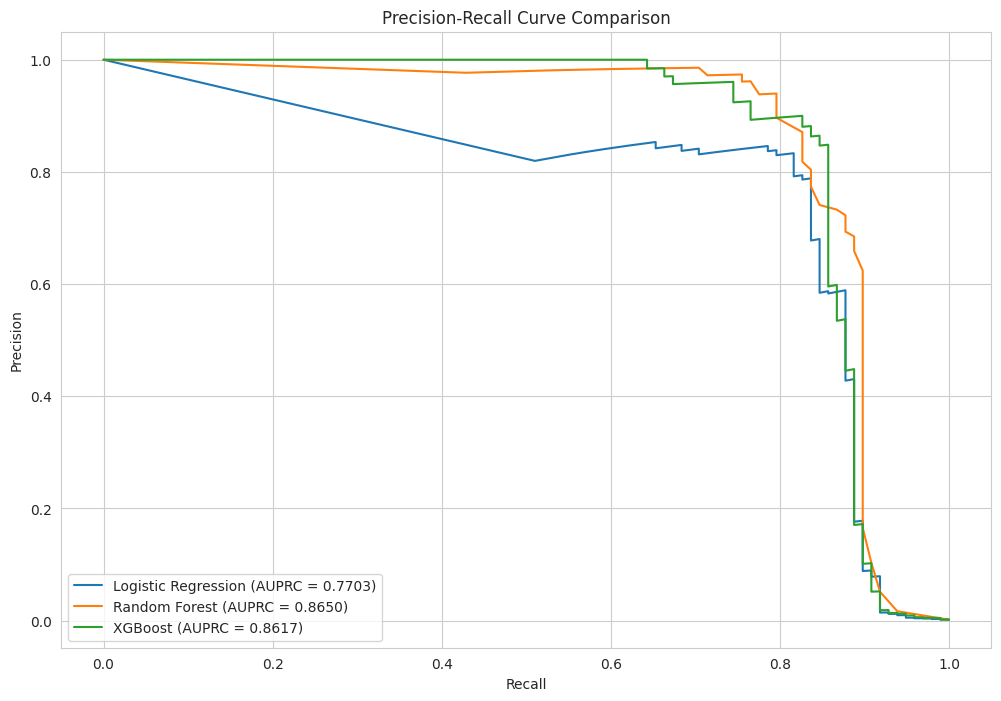

In [ ]:
plt.figure(figsize=(12, 8))

for name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res['y_proba'])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUPRC = {pr_auc:.4f})')

plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

## 6. Feature Importance Analysis

Let's examine which features were most influential for our best-performing model (typically XGBoost or Random Forest).

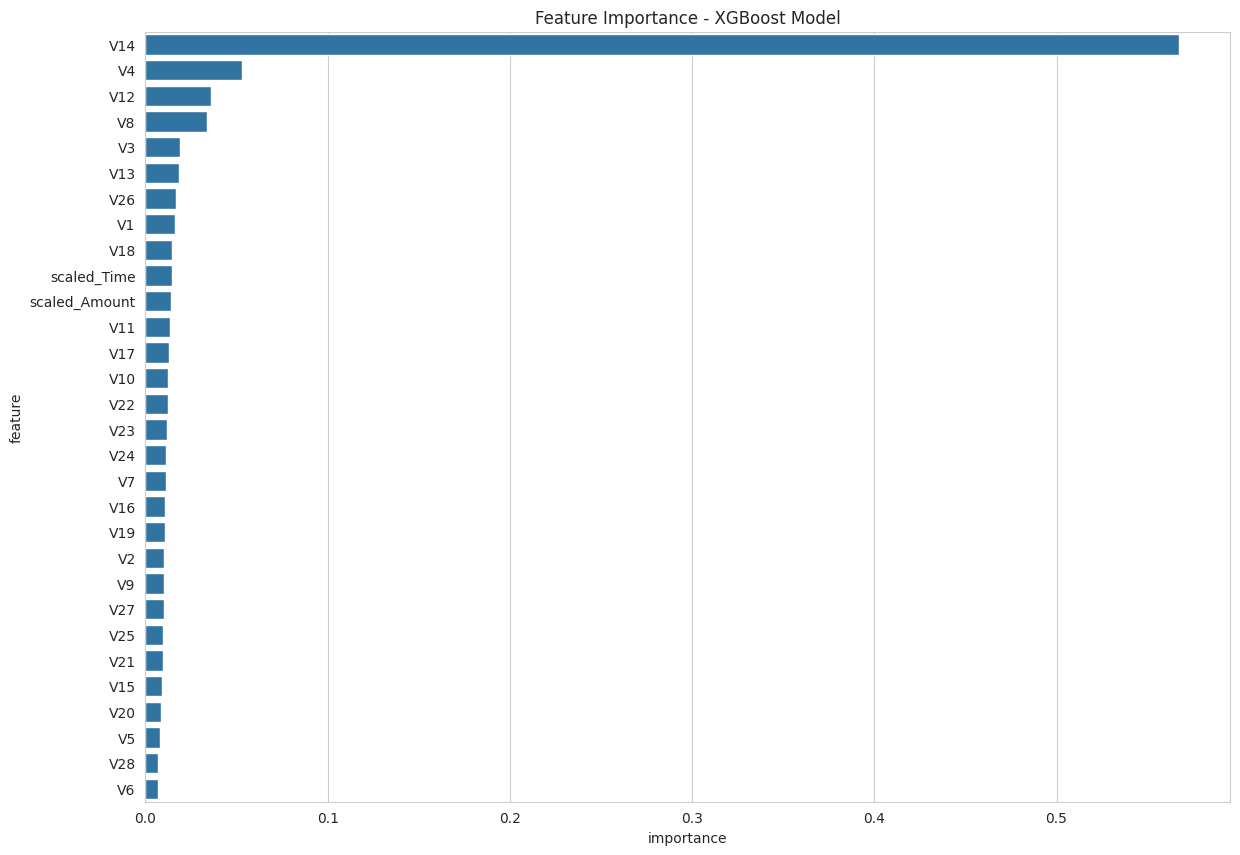

In [ ]:
best_model = models['XGBoost']
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(14, 10))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance - XGBoost Model')
plt.show()

## 7. Conclusion & Next Steps

In this project, we successfully built and evaluated several machine learning models for credit card fraud detection. By using SMOTE to handle the extreme class imbalance, we were able to train models that achieved high recall without drastically sacrificing precision.

The **XGBoost** and **Random Forest** models showed the strongest performance, as evidenced by their high Area Under the Precision-Recall Curve (AUPRC). The confusion matrices show that these models correctly identified a significant number of fraudulent transactions (high true positives) while keeping the number of legitimate transactions flagged as fraud (false positives) relatively low.

### Potential Improvements:
* **Hyperparameter Tuning:** Use techniques like GridSearchCV or RandomizedSearchCV to find the optimal hyperparameters for the best-performing models, which could further boost performance.
* **Anomaly Detection Algorithms:** Explore unsupervised anomaly detection methods like Isolation Forest or Autoencoders, which do not require labeled data and can be effective at identifying novel fraud patterns.
* **Feature Engineering:** Create new features that might capture fraudulent behavior more effectively, such as transaction frequency for a given card, or the time difference between transactions.
* **Deployment:** Package the final model into a real-time API using a framework like Flask or FastAPI, which could then be integrated into a payment processing pipeline to score transactions as they occur.